<p align="center"><img src="https://github.com/Reece323/air-scrape/blob/main/assets/airbnb_logo.png?raw=true" width="300"/></p>
<center> <h1> Analyzing AirBnB Listings </h1> </center>


### This project focuses on data gathered from AirBnB listings

#### Goals:

- _Manipulating and Exploring the data_
- _Creating Visualizations_
- _Use Machine Learning_
- _Determine which features attracts consumers_
- _See how to increase revenue as `host`_


### Imports

In [124]:
# Imports
# !pip install category_encoders rich
import json
import re
import time
import urllib.request
import warnings
from datetime import datetime

import category_encoders as ce
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from IPython.display import SVG
from keras import layers, models, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from matplotlib import colors as mcolors
from rich.console import Console
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import (accuracy_score, explained_variance_score,
                             mean_squared_error, r2_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import plot_importance


console = Console()
print = console.print


pd.options.display.max_columns = 4000

# plt.xkcd()
sns.set_context("talk")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": .1})


### Reading Data

In [160]:
bentonville = 'https://raw.githubusercontent.com/Reece323/air-scrape/main/AirBnB/Data/Bentonville_all.json'
response = urllib.request.urlopen(bentonville)
Bentonville = json.loads(response.read())

Bentonville_json_normalize = pd.json_normalize(Bentonville)
Bentonville_amenities = Bentonville_json_normalize['listingAmenities'].explode().apply(pd.Series)
Bentonville_amenities.rename(columns={col:f'amenities_{col}' for col in Bentonville_amenities.columns}, inplace=True)


cols = [col for col in Bentonville_json_normalize.columns if col not in ['amenities_records']]
Bentonville_json_normalize = Bentonville_json_normalize[cols].join(Bentonville_amenities)
Bentonville_json_normalize.dropna(axis=1, how='all', inplace=True)

In [126]:
df.head()

,url,name,stars,numberOfGuests,address,roomType,reviews,calendar,listingAmenities,rootAmenitySections,seeAllAmenitySections,bathroomLabel,bedLabel,bedroomLabel,hasHouseRules,id,isNewListing,listingRooms,p3SummaryAddress,photos,roomTypeCategory,tierId,hasSpecialOffer,maxNights,minNights,priceDetails,hasWeWorkLocation,isBusinessTravelReady,additionalHosts,isHostedBySuperhost,hometourRooms,hometourSections,descriptionLocale,initialDescriptionAuthorType,localizedCheckInTimeWindow,localizedCheckOutTime,city,country,countryCode,hasHostGuidebook,hasLocalAttractions,neighborhoodCommunityTags,state,paidGrowthRemarketingListingIds,hasCommercialHostInfo,reviewsOrder,hostQuote,nearbyAirportDistanceDescriptions,propertyTypeInCity,renderTierId,isHotel,showReviewTag,isRepresentativeInventory,localizedCity,highlights,highlightsImpressionId,categorizedPreviewAmenities,pointOfInterests,pageViewType,previewTags,seeAllHometourSections,enableHighlightsVoting,listingExpectations,localizedListingExpectations,additionalHouseRules,sortedReviews,documentDisplayPictures,sections,p3ImpressionId,idStr,paidGrowthRemarketingListingIdsStr,location.lat,location.lng,pricing.rate.amount,pricing.rate.amount_formatted,pricing.rate.currency,pricing.rate.is_micros_accuracy,pricing.rate_type,pricing.rate_with_service_fee.amount,pricing.rate_with_service_fee.amount_formatted,pricing.rate_with_service_fee.currency,pricing.rate_with_service_fee.is_micros_accuracy,primaryHost.about,primaryHost.badges,primaryHost.firstName,primaryHost.id,primaryHost.isSuperhost,primaryHost.memberSinceFullStr,primaryHost.name,primaryHost.languages,primaryHost.pictureUrl,primaryHost.responseRateWithoutNa,primaryHost.responseTimeWithoutNa,primaryHost.hasInclusionBadge,primaryHost.pictureLargeUrl,primaryHost.hostIntroTags,primaryHost.hostUrl,primaryHost.listingsCount,primaryHost.totalListingsCount,sectionedDescription.access,sectionedDescription.authorType,sectionedDescription.description,sectionedDescription.houseRules,sectionedDescription.interaction,sectionedDescription.locale,sectionedDescription.localizedLanguageName,sectionedDescription.name,sectionedDescription.neighborhoodOverview,sectionedDescription.notes,sectionedDescription.space,sectionedDescription.summary,sectionedDescription.transit,guestControls.allowsChildren,guestControls.allowsEvents,guestControls.allowsInfants,guestControls.allowsPets,guestControls.allowsSmoking,guestControls.personCapacity,guestControls.structuredHouseRules,guestControls.structuredHouseRulesWithTips,guestControls.allowsNonChinaUsers,reviewDetailsInterface.reviewCount,reviewDetailsInterface.reviewSummary,hostSignatureFont.url,hostGuidebook.guidebookUrl,hostGuidebook.localizedNameForHomesPdp,hostGuidebook.title,hostGuidebook.id,heroModule.categorizedPhotos,reviewsModule.localizedOverallRating,reviewsModule.appreciationTags,accessibilityModule.amenities,accessibilityModule.rootHighlights,accessibilityModule.seeAllSections,accessibilityModule.seeAllSummary,coverPhotoPrimary.id,coverPhotoPrimary.listingId,coverPhotoPrimary.mediaType,coverPhotoPrimary.mediaId,coverPhotoPrimary.caption,coverPhotoPrimary.roomId,coverPhotoPrimary.cover,coverPhotoPrimary.shotType,coverPhotoPrimary.orientation,coverPhotoPrimary.originalUrl,coverPhotoPrimary.extraLargeUrl,coverPhotoPrimary.extraMediumUrl,coverPhotoPrimary.largeUrl,coverPhotoPrimary.smallUrl,coverPhotoPrimary.thumbnailUrl,coverPhotoPrimary.thumbnailPng,coverPhotoPrimary.dominantSaturatedColor,coverPhotoPrimary.extraExtraLargeUrl,coverPhotoPrimary.listingIdStr,coverPhotoVertical.id,coverPhotoVertical.listingId,coverPhotoVertical.mediaType,coverPhotoVertical.mediaId,coverPhotoVertical.caption,coverPhotoVertical.roomId,coverPhotoVertical.cover,coverPhotoVertical.shotType,coverPhotoVertical.orientation,coverPhotoVertical.originalUrl,coverPhotoVertical.extraLargeUrl,coverPhotoVertical.extraMediumUrl,coverPhotoVertical.largeUrl,coverPhotoVertical.smallUrl,coverPhotoVertical.thumbnailUrl,coverPhotoVertical.thumbnailPng,cov

### Dropping unused data

In [127]:
cols_to_drop_temp = [
    # 'url',
    "calendar",
    # 'rootAmenitySections',
    'p3SummaryAddress',
    'primaryHost.about',
    'primaryHost.badges',
    'primaryHost.firstName',
    'primaryHost.id',
    'primaryHost.isSuperhost',
    'primaryHost.memberSinceFullStr',
    'primaryHost.name',
    'primaryHost.languages',
    'primaryHost.pictureUrl',
    'primaryHost.responseRateWithoutNa',
    'primaryHost.responseTimeWithoutNa',
    'primaryHost.hasInclusionBadge',
    'primaryHost.pictureLargeUrl',
    'primaryHost.hostIntroTags',
    'primaryHost.hostUrl',
    'primaryHost.listingsCount',
    'primaryHost.totalListingsCount',
    'tierId',
    'hasSpecialOffer',
    'hasWeWorkLocation',
    'hasWeWorkLocation',
    'additionalHosts',
    'hometourRooms',
    'hometourSections',
    'descriptionLocale',
    'initialDescriptionAuthorType',
    'localizedCheckInTimeWindow',
    'localizedCheckOutTime',
    'hometourRooms',
    'countryCode',
    'hasHostGuidebook',
    'hasLocalAttractions',
    'neighborhoodCommunityTags',
    'state',
    'paidGrowthRemarketingListingIds',
    'hasCommercialHostInfo',
    'hostSignatureFont.url',
    'nearbyAirportDistanceDescriptions',
    'propertyTypeInCity',
    'renderTierId',
    'isHotel',
    'isNewListing',
    'showReviewTag',
    'isRepresentativeInventory',
    'localizedCity',
    'highlights',
    'highlightsImpressionId',
    'pointOfInterests',
    'hostGuidebook.guidebookUrl',
    'hostGuidebook.localizedNameForHomesPdp',
    'hostGuidebook.title',
    'hostGuidebook.id',
    'pageViewType',
    'previewTags',
    'seeAllHometourSections',
    'enableHighlightsVoting',
    'heroModule.categorizedPhotos',
    'sortedReviews',
    'documentDisplayPictures',
    'sections',
    'p3ImpressionId',
    'paidGrowthRemarketingListingIdsStr',
    'isBusinessTravelReady',
    'address',
    'hasHouseRules',
    'reviewsOrder',
    'hostQuote',
    'localizedListingExpectations',
    'pricing.rate.amount_formatted',
    'pricing.rate.currency',
    'pricing.rate.is_micros_accuracy',
    'pricing.rate_with_service_fee.amount_formatted',
    'pricing.rate_with_service_fee.currency',
    'pricing.rate_with_service_fee.is_micros_accuracy',
    'reviewDetailsInterface.reviewSummary',
    'reviewsModule.appreciationTags',
    'pricing.rate_with_service_fee.amount',
    'pricing.rate_type',
    'sectionedDescription.authorType',
    'sectionedDescription.locale',
    'sectionedDescription.localizedLanguageName',
    'sectionedDescription.notes',
    'sectionedDescription.space',
    'guestControls.allowsNonChinaUsers',
    'guestControls.structuredHouseRulesWithTips',
    'sectionedDescription.neighborhoodOverview',
    'sectionedDescription.access',
    'sectionedDescription.description',
    'sectionedDescription.interaction',
    'sectionedDescription.name',
    'sectionedDescription.summary',
    'sectionedDescription.transit',
    # 'name',
    'listingExpectations',
    'sectionedDescription.houseRules',
    'additionalHouseRules',
    'idStr'
]

df = df.drop(cols_to_drop_temp, axis=1)
# df.columns


### Cleaning numerical values in Bedrooms, Beds, and Bathrooms

In [128]:
# function to check dtypes and % of unique values
def checking(df_to_check):
    print(f"Cleaned data type: {df_to_check.dtype}")
    print(
        f'% of listings with # unique: \n{df_to_check.value_counts(normalize=True)}\n')

# 'rooms'
df['bedroomLabel'] = df['bedroomLabel'].replace('Studio', '0 bedrooms')
new = df["bathroomLabel"].str.split(" ", n=1, expand=True)
# making separate column from new data frame
df["rooms"] = new[0]
# checking 'rooms'
# checking(df.rooms)


new1 = df["bedLabel"].str.split(" ", n=1, expand=True)
# making separate column from new data frame
df["beds"] = new1[0]
# checking 'rooms'
# checking(df.beds)


new = df["bathroomLabel"].str.split(" ", n=1, expand=True)
df['baths'] = new[0].astype(float)
# checking(df.baths)
df.columns = [re.sub("[ ,\$]", "_", re.sub("[.]", "", c)) for c in df.columns]


### temporary dropping of data columns

In [129]:
dropme = ['name', 'country', 'listingRooms', 'roomType',
          'bedroomLabel', 'bedLabel', 'bathroomLabel',
          'seeAllAmenitySections', 'categorizedPreviewAmenities',
          'reviewsModulelocalizedOverallRating',
          'priceDetails',
          'guestControlsallowsChildren', 'guestControlsallowsEvents',
          'guestControlsallowsInfants', 'guestControlsallowsPets',
          'guestControlsallowsSmoking', 'guestControlspersonCapacity', 'photos',
          'guestControlsstructuredHouseRules','amenities_selectListViewPhoto', 'amenities_selectTileViewPhoto',
          'listingAmenities','amenities_description',  'reviews'
          ]

df = df.drop(dropme, axis=1)

In [130]:
# Renaming
df = df.rename(
    columns={
        'reviewDetailsInterfacereviewCount': 'reviewCount',
        'isHostedBySuperhost': 'Superhost',
        'roomTypeCategory': 'listingType',
        'pricingrateamount': 'pricepernight', 
    }
)

df.Superhost = df.Superhost.astype(np.int64)

# Reordering
df = df.reindex(
    columns=[
        'pricepernight', 'city', 'listingType', 'stars', 'reviewCount','id', 'url', 'Superhost',
        'minNights', 'maxNights','numberOfGuests', 'rooms', 'beds', 'baths', 'locationlat',
        'locationlng', 'amenities_id',
       'amenities_isPresent', 'amenities_name',
       
    ]
)

# df = df.set_index('id')


### Checking out current state of data versus raw data

In [131]:
df.describe()

,pricepernight,stars,reviewCount,id,Superhost,minNights,maxNights,numberOfGuests,baths,locationlat,locationlng,amenities_id
count,11065.000000,10735.000000,11065.000000,1.106500e+04,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000
mean,116.190691,4.981556,88.850791,3.981736e+07,0.816087,1.998464,600.779214,4.785540,1.496972,36.377398,-94.209082,114.397198
std,51.940344,0.094249,93.155664,1.274709e+07,0.387431,3.042168,503.531268,2.020594,0.587026,0.028568,0.030173,161.966728
min,29.000000,4.500000,0.000000,6.194634e+06,0.000000,1.000000,3.000000,2.000000,1.000000,36.271990,-94.311010,1.000000
25%,87.000000,5.000000,19.000000,2.858619e+07,1.000000,1.000000,30.000000,4.000000,1.000000,36.366210,-94.217490,36.000000
50%,110.000000,5.000000,59.000000,4.504980e+07,1.000000,2.000000,365.000000,4.000000,1.000000,36.372810,-94.210480,61.000000
75%,137.000000,5.000000,129.000000,5.041347e+07,1.000000,2.000000,1125.000000,6.000000,2.000000,36.383000,-94.203720,96.000000
max,380.000000,5.000000,606.000000,5.437005e+07,1.000000,30.000000,1125.000000,12.000000,3.500000,36.472050,-94.107870,672.000000


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11065 entries, 0 to 271
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pricepernight        11065 non-null  int64  
 1   city                 11065 non-null  object 
 2   listingType          11065 non-null  object 
 3   stars                10735 non-null  float64
 4   reviewCount          11065 non-null  int64  
 5   id                   11065 non-null  int64  
 6   url                  11065 non-null  object 
 7   Superhost            11065 non-null  int64  
 8   minNights            11065 non-null  int64  
 9   maxNights            11065 non-null  int64  
 10  numberOfGuests       11065 non-null  int64  
 11  rooms                11065 non-null  object 
 12  beds                 11065 non-null  object 
 13  baths                11065 non-null  float64
 14  locationlat          11065 non-null  float64
 15  locationlng          11065 non-null  f

In [133]:
df['listingType'] = df['listingType'].replace(['entire_home','private_room'],[1,0])
df.listingType.value_counts(normalize=True)
df['city'] = df['city'].replace(['Bentonville','Bella Vista','Rogers', 'Centerton', 'Cave Springs'],[1,2,3,4,5])
df = pd.get_dummies(df, columns=['amenities_name'])
df.columns = [re.sub("[ ,\$]", "_", re.sub("[.]", "", c)) for c in df.columns]

### Checking out amenities
print(f'DF before removing False Amenities:\n\n{df.shape}')
df = df[df.amenities_isPresent != False]
print(f'DF AFTER removing False Amenities:\n\n{df.shape}')
df = df.drop(columns=["amenities_isPresent", "amenities_id"])
print(f'Since all amenities are now True, removing isPresent column\n\n{df.shape}')

DF before removing False Amenities:

(11065, 133)

DF AFTER removing False Amenities:

(10836, 133)

Since all amenities are now True, removing isPresent column

(10836, 131)

In [134]:
# When using pandas explode, all amenities had their own rows per group
# this adds them together, now having one row per all amenities per all unique ID values

id_group = df.groupby(['id'])
df = id_group.max()
df

,pricepernight,city,listingType,stars,reviewCount,url,Superhost,minNights,maxNights,numberOfGuests,rooms,beds,baths,locationlat,locationlng,amenities_name_Air_conditioning,amenities_name_BBQ_grill,amenities_name_Baby_bath,amenities_name_Baby_monitor,amenities_name_Baby_safety_gates,amenities_name_Babysitter_recommendations,amenities_name_Backyard,amenities_name_Baking_sheet,amenities_name_Barbecue_utensils,amenities_name_Bathroom_essentials,amenities_name_Bathtub,amenities_name_Bed_linens,amenities_name_Bedroom_comforts,amenities_name_Bidet,amenities_name_Bikes,amenities_name_Board_games,amenities_name_Boat_slip,amenities_name_Body_soap,amenities_name_Bread_maker,amenities_name_Breakfast,amenities_name_Cable_TV,amenities_name_Carbon_monoxide_alarm,amenities_name_Ceiling_fan,amenities_name_Changing_table,amenities_name_Children’s_books_and_toys,amenities_name_Children’s_dinnerware,amenities_name_Cleaning_before_checkout,amenities_name_Cleaning_products,amenities_name_Clothing_storage,amenities_name_Coffee_maker,amenities_name_Conditioner,amenities_name_Cooking_basics,amenities_name_Crib,amenities_name_Dedicated_workspace,amenities_name_Dining_table,amenities_name_Dishes_and_silverware,amenities_name_Dishwasher,amenities_name_Dryer,amenities_name_Drying_rack_for_clothing,amenities_name_EV_charger,amenities_name_Elevator,amenities_name_Essentials,amenities_name_Ethernet_connection,amenities_name_Extra_pillows_and_blankets,amenities_name_Fire_extinguisher,amenities_name_Fire_pit,amenities_name_Fireplace_guards,amenities_name_First_aid_kit,amenities_name_Free_parking_on_premises,amenities_name_Free_street_parking,amenities_name_Freezer,amenities_name_Full_kitchen,amenities_name_Game_console,amenities_name_Gym,amenities_name_Hair_dryer,amenities_name_Hangers,amenities_name_Heating,amenities_name_High_chair,amenities_name_Host_greets_you,amenities_name_Hot_tub,amenities_name_Hot_water,amenities_name_Hot_water_kettle,amenities_name_Indoor_fireplace,amenities_name_Iron,amenities_name_Kayak,amenities_name_Keurig_coffee_machine,amenities_name_Keypad,amenities_name_Kitchen,amenities_name_Lake_access,amenities_name_Laundromat_nearby,amenities_name_Lock_on_bedroom_door,amenities_name_Lockbox,amenities_name_Long_term_stays_allowed,amenities_name_Luggage_dropoff_allowed,amenities_name_Microwave,amenities_name_Mini_fridge,amenities_name_Nespresso_machine,amenities_name_Outdoor_dining_area,amenities_name_Outdoor_furniture,amenities_name_Outdoor_shower,amenities_name_Outlet_covers,amenities_name_Oven,amenities_name_Pack_’n_play/Travel_crib,amenities_name_Paid_parking_on_premises,amenities_name_Patio_or_balcony,amenities_name_Piano,amenities_name_Ping_pong_table,amenities_name_Pocket_wifi,amenities_name_Pool,amenities_name_Pool_table,amenities_name_Portable_fans,amenities_name_Pour-over_coffee,amenities_name_Private_entrance,amenities_name_Record_player,amenities_name_Refrigerator,amenities_name_Rice_maker,amenities_name_Room-darkening_shades,amenities_name_Safe,amenities_name_Self_check-in,amenities_name_Shampoo,amenities_name_Shower_gel,amenities_name_Single_level_home,amenities_name_Smart_lock,amenities_name_Smoke_alarm,amenities_name_Sound_system,amenities_name_Stove,amenities_name_TV,amenities_name_Table_corner_guards,amenities_name_Toaster,amenities_name_Trash_compactor,amenities_name_Washer,amenities_name_Waterfront,amenities_name_Wifi,amenities_name_Window_guards,amenities_name_Wine_glasses
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6194634,104,1,1,5.0,245,https://www.airbnb.com/rooms/6194634,1,2,60,6,1,2,1.0,36.36961,-94.21268,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,1,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0
7512762,196,1,1,5.0,383,https://www.airbnb.com/rooms/7512762,1,1,1125,7,2,4,2.0,36.37422,-94.21609

### Analyzing numerical data

In [135]:
df['rooms'] = df['rooms'].astype(float)
df['beds'] = df['beds'].astype(float)

In [136]:
for col in ['amenities_name_Air_conditioning','amenities_name_Backyard']:
  uni_val_col = df[col].unique()
  print(f'The unique values in {col} are {uni_val_col}')

for col in ['amenities_name_Air_conditioning','amenities_name_Backyard']:
  df[col] = pd.to_numeric(df[col], errors='coerce')
  
  
## Create a dataframe with continuous columns 
df_cont = df.select_dtypes(include = ['int64','float64', 'uint8'])## Create a dataframe with categorical columns 
df_cat = df.select_dtypes(include =['object'])

The unique values in amenities_name_Air_conditioning are [1]

The unique values in amenities_name_Backyard are [1 0]

In [137]:
imputer = KNNImputer(n_neighbors=10) 
df_data = imputer.fit_transform(df_cont)## Creating a new dataframe of the imputed data
df_num = pd.DataFrame(df_data, columns = df_cont.columns)
df_num.sample(10).style.background_gradient(axis=0)

,pricepernight,city,listingType,stars,reviewCount,Superhost,minNights,maxNights,numberOfGuests,rooms,beds,baths,locationlat,locationlng,amenities_name_Air_conditioning,amenities_name_BBQ_grill,amenities_name_Baby_bath,amenities_name_Baby_monitor,amenities_name_Baby_safety_gates,amenities_name_Babysitter_recommendations,amenities_name_Backyard,amenities_name_Baking_sheet,amenities_name_Barbecue_utensils,amenities_name_Bathroom_essentials,amenities_name_Bathtub,amenities_name_Bed_linens,amenities_name_Bedroom_comforts,amenities_name_Bidet,amenities_name_Bikes,amenities_name_Board_games,amenities_name_Boat_slip,amenities_name_Body_soap,amenities_name_Bread_maker,amenities_name_Breakfast,amenities_name_Cable_TV,amenities_name_Carbon_monoxide_alarm,amenities_name_Ceiling_fan,amenities_name_Changing_table,amenities_name_Children’s_books_and_toys,amenities_name_Children’s_dinnerware,amenities_name_Cleaning_before_checkout,amenities_name_Cleaning_products,amenities_name_Clothing_storage,amenities_name_Coffee_maker,amenities_name_Conditioner,amenities_name_Cooking_basics,amenities_name_Crib,amenities_name_Dedicated_workspace,amenities_name_Dining_table,amenities_name_Dishes_and_silverware,amenities_name_Dishwasher,amenities_name_Dryer,amenities_name_Drying_rack_for_clothing,amenities_name_EV_charger,amenities_name_Elevator,amenities_name_Essentials,amenities_name_Ethernet_connection,amenities_name_Extra_pillows_and_blankets,amenities_name_Fire_extinguisher,amenities_name_Fire_pit,amenities_name_Fireplace_guards,amenities_name_First_aid_kit,amenities_name_Free_parking_on_premises,amenities_name_Free_street_parking,amenities_name_Freezer,amenities_name_Full_kitchen,amenities_name_Game_console,amenities_name_Gym,amenities_name_Hair_dryer,amenities_name_Hangers,amenities_name_Heating,amenities_name_High_chair,amenities_name_Host_greets_you,amenities_name_Hot_tub,amenities_name_Hot_water,amenities_name_Hot_water_kettle,amenities_name_Indoor_fireplace,amenities_name_Iron,amenities_name_Kayak,amenities_name_Keurig_coffee_machine,amenities_name_Keypad,amenities_name_Kitchen,amenities_name_Lake_access,amenities_name_Laundromat_nearby,amenities_name_Lock_on_bedroom_door,amenities_name_Lockbox,amenities_name_Long_term_stays_allowed,amenities_name_Luggage_dropoff_allowed,amenities_name_Microwave,amenities_name_Mini_fridge,amenities_name_Nespresso_machine,amenities_name_Outdoor_dining_area,amenities_name_Outdoor_furniture,amenities_name_Outdoor_shower,amenities_name_Outlet_covers,amenities_name_Oven,amenities_name_Pack_’n_play/Travel_crib,amenities_name_Paid_parking_on_premises,amenities_name_Patio_or_balcony,amenities_name_Piano,amenities_name_Ping_pong_table,amenities_name_Pocket_wifi,amenities_name_Pool,amenities_name_Pool_table,amenities_name_Portable_fans,amenities_name_Pour-over_coffee,amenities_name_Private_entrance,amenities_name_Record_player,amenities_name_Refrigerator,amenities_name_Rice_maker,amenities_name_Room-darkening_shades,amenities_name_Safe,amenities_name_Self_check-in,amenities_name_Shampoo,amenities_name_Shower_gel,amenities_name_Single_level_home,amenities_name_Smart_lock,amenities_name_Smoke_alarm,amenities_name_Sound_system,amenities_name_Stove,amenities_name_TV,amenities_name_Table_corner_guards,amenities_name_Toaster,amenities_name_Trash_compactor,amenities_name_Washer,amenities_name_Waterfront,amenities_name_Wifi,amenities_name_Window_guards,amenities_name_Wine_glasses
143,110.000000,1.000000,1.000000,4.500000,42.000000,0.000000,2.000000,1125.000000,6.000000,1.000000,4.000000,1.000000,36.383120,-94.219550,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,

### and now categorical data

In [138]:
# Percentage of missing values in each dataframe along with visualization
total = df_cat.isnull().sum().sort_values(ascending=False)
percent = df_cat.isnull().sum()/df_cat.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.style.background_gradient(axis=1)

,Total,Percent
url,0,0.000000


In [139]:
print(f"Missing_Values_count:\n\n{df.isna().sum()}")

Missing_Values_count:

pricepernight                    0
city                             0
listingType                      0
stars                           11
reviewCount                      0
                                ..
amenities_name_Washer            0
amenities_name_Waterfront        0
amenities_name_Wifi              0
amenities_name_Window_guards     0
amenities_name_Wine_glasses      0
Length: 130, dtype: int64

In [140]:
mean_value=df['stars'].mean()
df.stars.fillna(value=mean_value, inplace=True)

In [141]:
print(f"Missing_Values_count:\n\n{df.isna().sum()}")

Missing_Values_count:

pricepernight                   0
city                            0
listingType                     0
stars                           0
reviewCount                     0
                               ..
amenities_name_Washer           0
amenities_name_Waterfront       0
amenities_name_Wifi             0
amenities_name_Window_guards    0
amenities_name_Wine_glasses     0
Length: 130, dtype: int64

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272 entries, 6194634 to 54370049
Columns: 130 entries, pricepernight to amenities_name_Wine_glasses
dtypes: float64(6), int64(8), object(1), uint8(115)
memory usage: 64.5+ KB


### Visualization of numerical columns

In [143]:
# ## Plot displot for continuous data columns
# for col in df_num.columns:
#   sns.histplot(df_num[col], alpha=0.5);
#   plt.figure();

### ...categorical columns

In [144]:
# cat_cols = ['city', 'listingType']
# ## Plotting bar plots for categorical data columns
# for col in cat_cols:
#     plt.figure()
#     sns.countplot(x=col, data=df_cat)
#     plt.xticks(rotation=45)

### Outliers

In [145]:
# outliers

df_outliers = pd.DataFrame(index=df_num.columns, columns=['outliers', 'outliers%'])

for col in df_num.columns:
    if any(x in str(df_num[col].dtype)for x in ['int', 'float']):
        
        df_outliers.loc[col, 'count'] = len(df_num)
        df_outliers.loc[col, 'q1'] = df_num[col].quantile(0.25)
        df_outliers.loc[col, 'q3'] = df_num[col].quantile(0.75)
        df_outliers.loc[col, 'iqr'] = df_outliers.loc[col, 'q3'] - df_outliers.loc[col, 'q1']
        df_outliers.loc[col, 'lower'] = df_outliers.loc[col, 'q1'] - (3 * df_outliers.loc[col, 'iqr'])
        df_outliers.loc[col, 'upper'] = df_outliers.loc[col, 'q3'] + (3 * df_outliers.loc[col, 'iqr'])
        df_outliers.loc[col, 'min'] = df[col].min()
        df_outliers.loc[col, 'max'] = df[col].max()
        df_outliers.loc[col, 'outliers'] = ((df_num[col] < df_outliers.loc[col, 'lower']) | (df[col] > df_outliers.loc[col,'upper'])).sum()
        df_outliers.loc[col, 'outliers%'] = np.round(df_outliers.loc[col,
        'outliers'] / len(df_num) *100)
        
df_outliers

,outliers,outliers%,count,q1,q3,iqr,lower,upper,min,max
pricepernight,0,0.0,272.0,85.00,135.25,50.25,-65.75,286.00,29.0,380.0
city,0,0.0,272.0,1.00,1.00,0.00,1.00,1.00,1.0,5.0
listingType,21,8.0,272.0,1.00,1.00,0.00,1.00,1.00,0.0,1.0
stars,22,8.0,272.0,5.00,5.00,0.00,5.00,5.00,4.5,5.0
reviewCount,0,0.0,272.0,19.75,129.50,109.75,-309.50,458.75,0.0,606.0
...,...,...,...,...,...,...,...,...,...,...
amenities_name_Washer,43,16.0,272.0,1.00,1.00,0.00,1.00,1.00,0.0,1.0
amenities_name_Waterfront,0,0.0,272.0,0.00,0.00,0.00,0.00,0.00,0.0,1.0
amenities_name_Wifi,1,0.0,272.0,1.00,1.00,0.00,1.00,1.00,0.0,1.0
amenities_name_Window_guards,0,0.0,272.0,0.00,0.00,0.00,0.00,0.00,0.0,1.0


### Checking feature correlation

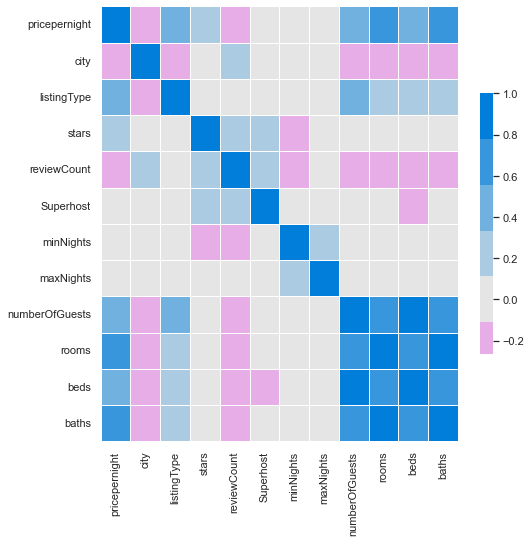

In [146]:
f, ax = plt.subplots(figsize=(8, 8), edgecolor='black')
cmap = sns.blend_palette(["#ec00ec", ".9", "#007ed9"], 9)

sns.heatmap(df[['pricepernight',
 'city',
 'listingType',
 'stars',
 'reviewCount',
#  'id',
 'url',
 'Superhost',
 'minNights',
 'maxNights',
 'numberOfGuests',
 'rooms',
 'beds',
 'baths']].corr(), linewidth=1, cmap=cmap, center=0, square=False, cbar_kws={"shrink": .6});

### setting up for machine learning

In [147]:
#Features
y = df['pricepernight']
X = df.drop(columns=['pricepernight', 'url'])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

print(f'X_train:\n\n{X_train.shape}\n\n\ny_train:\n\n{y_train.shape}\n\n\nX_test:\n\n{X_test.shape}\n\n\ny_test:\n\n{y_test.shape}')

X_train:

(190, 128)


y_train:

(190,)


X_test:

(82, 128)


y_test:

(82,)

In [148]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.70) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['#ec00ec', '#007ed9'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).pricepernight.median().plot(kind='bar', ax=ax2, color=['#ec00ec', '#007ed9'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (£)')
    ax2.set_xlabel('')
    
    plt.show()

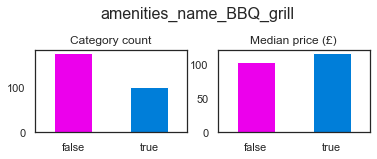

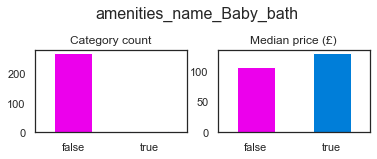

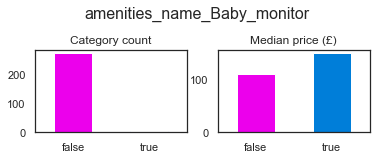

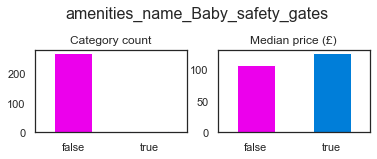

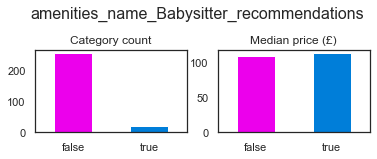

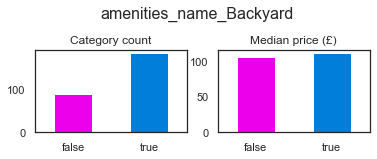

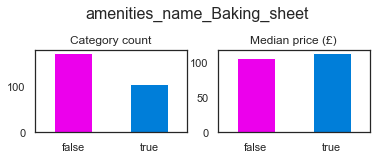

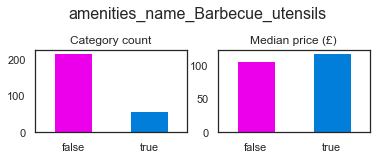

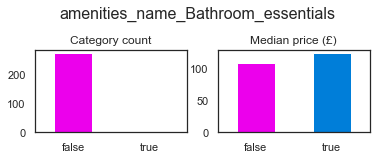

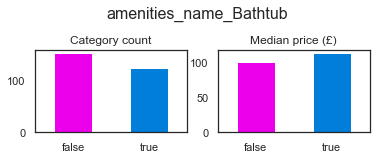

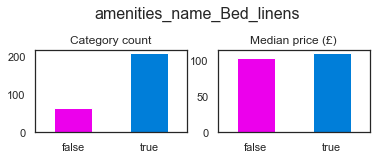

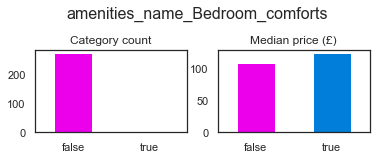

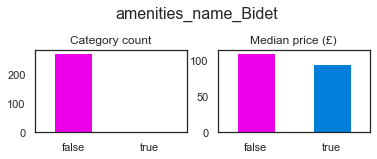

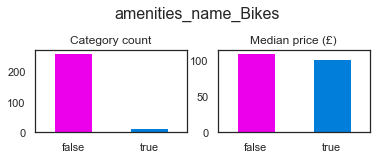

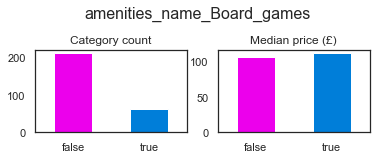

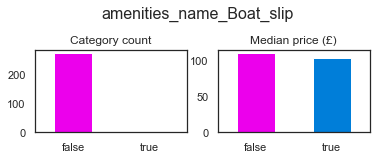

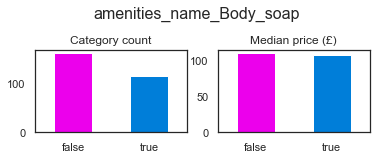

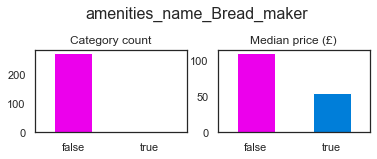

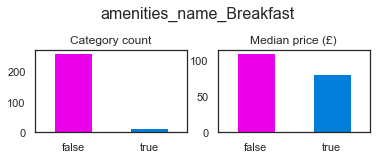

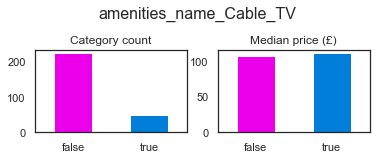

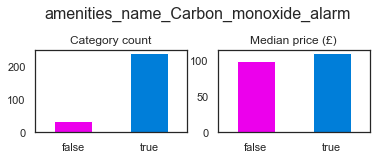

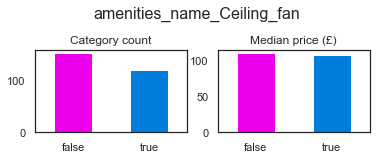

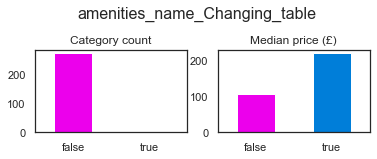

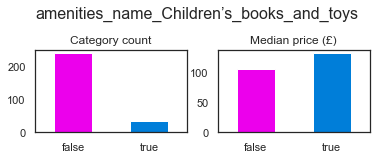

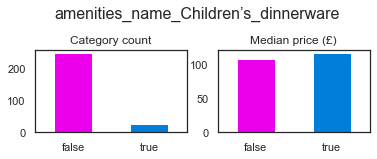

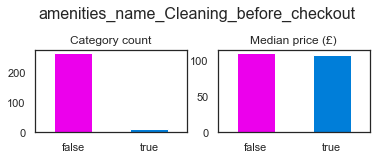

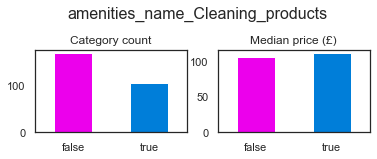

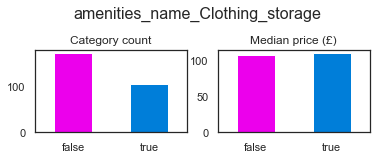

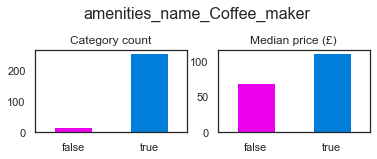

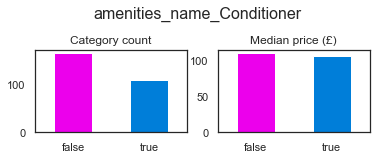

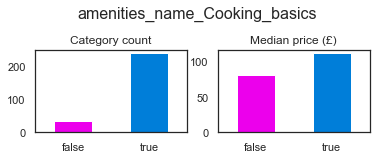

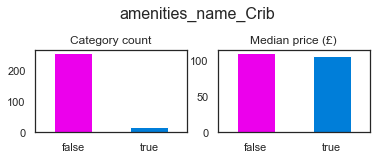

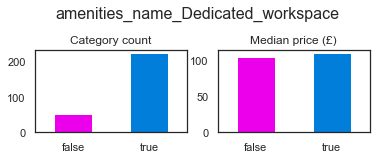

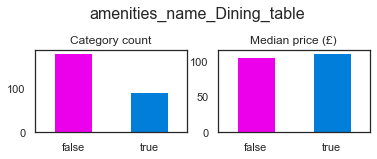

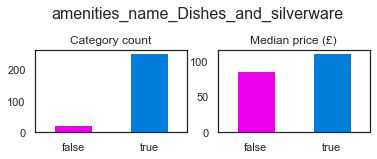

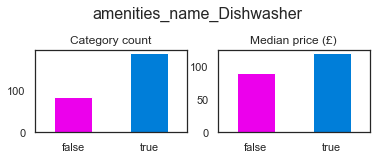

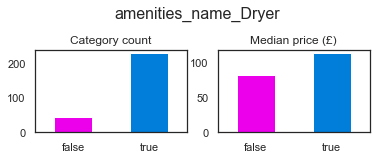

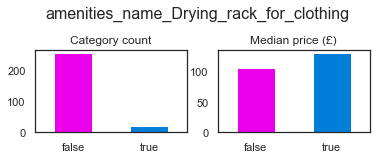

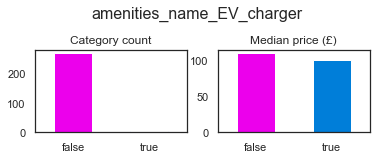

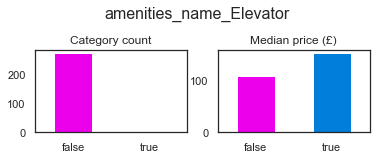

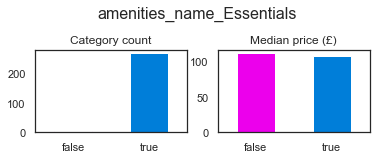

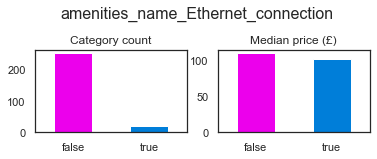

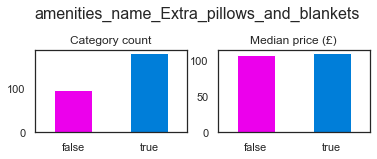

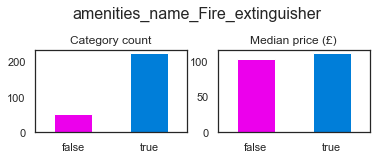

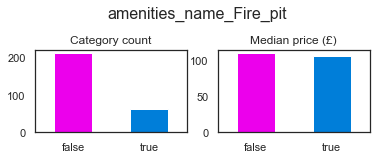

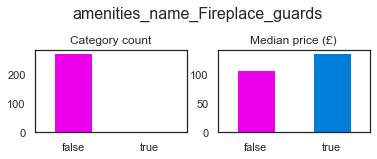

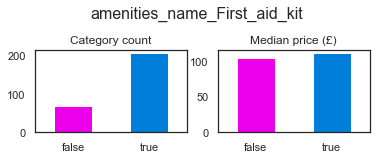

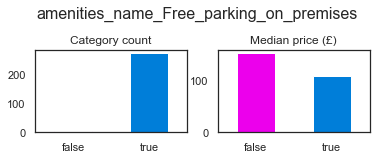

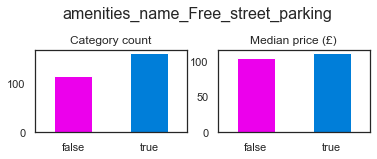

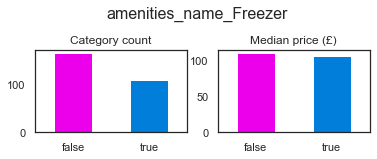

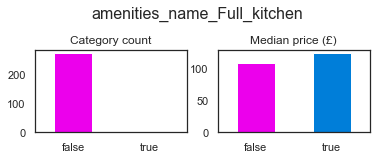

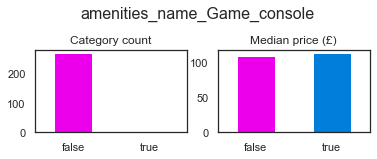

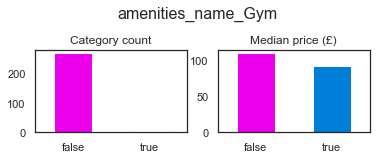

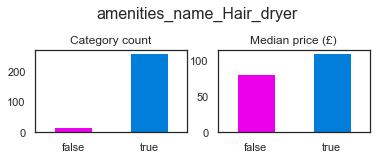

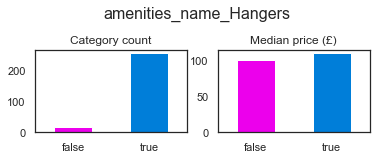

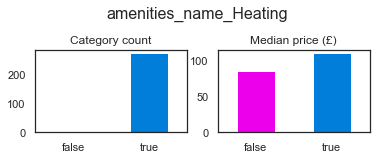

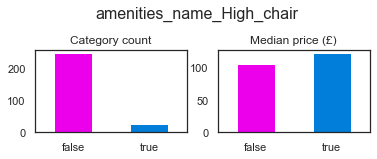

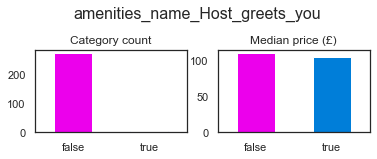

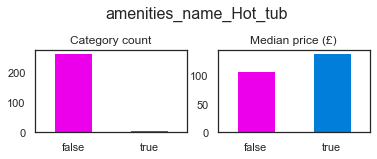

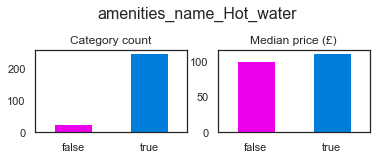

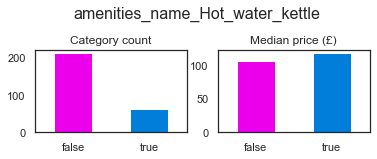

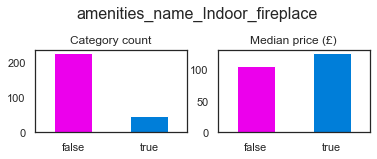

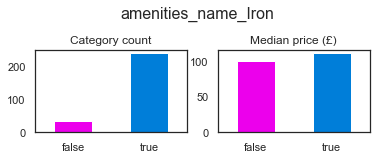

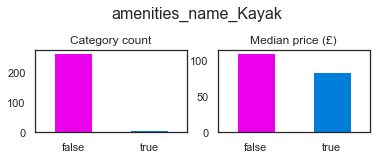

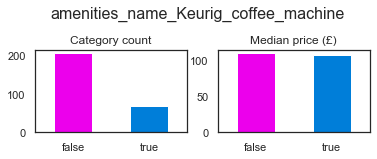

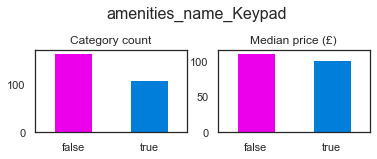

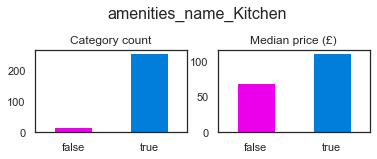

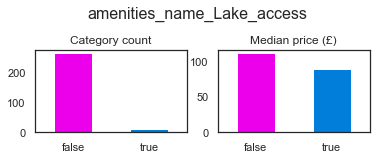

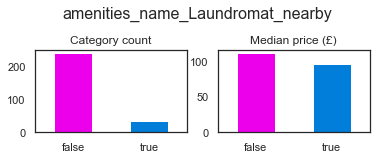

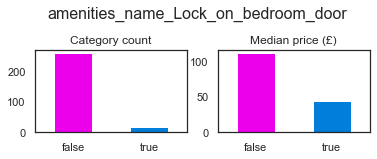

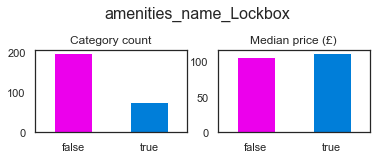

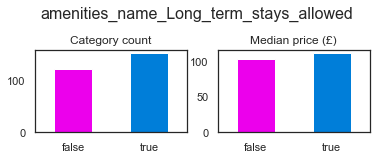

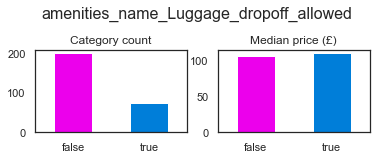

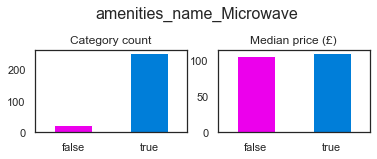

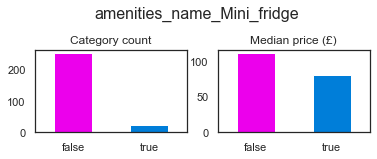

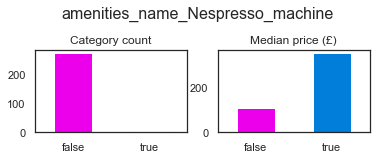

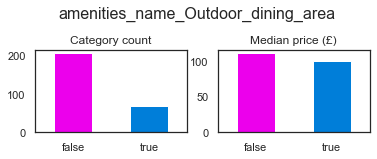

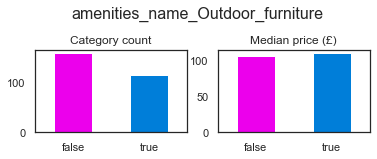

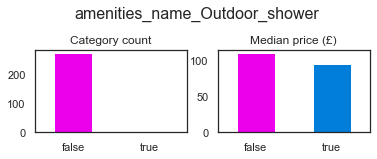

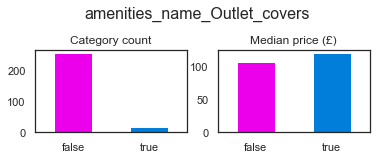

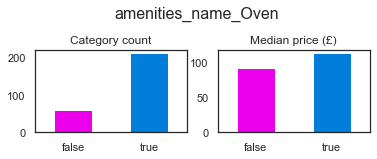

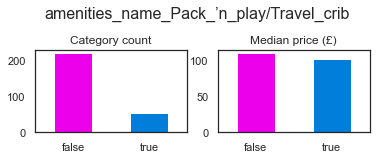

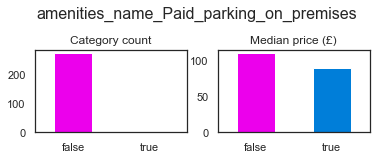

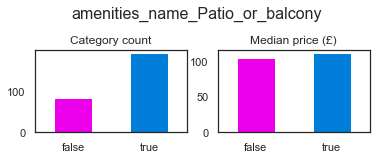

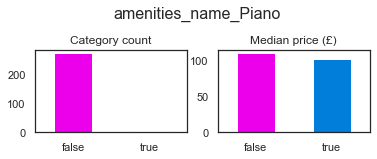

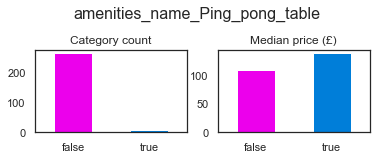

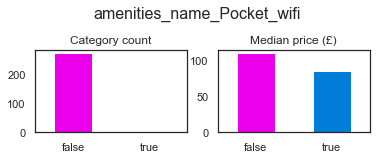

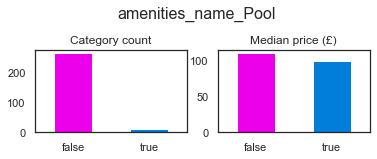

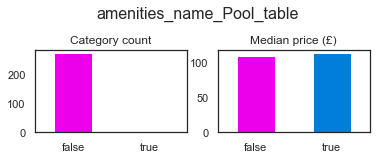

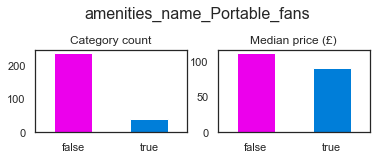

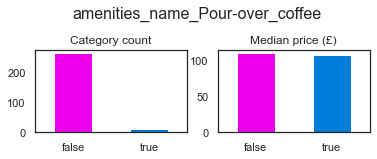

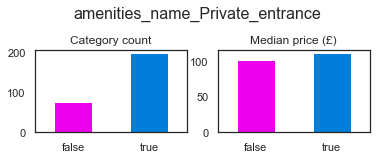

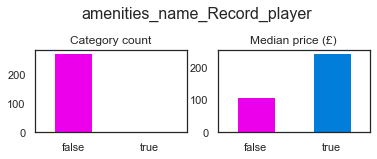

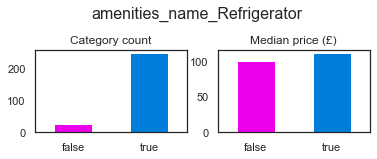

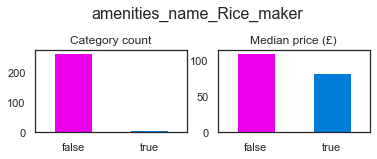

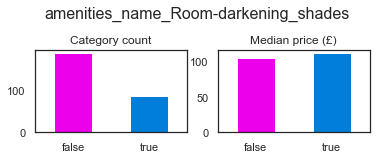

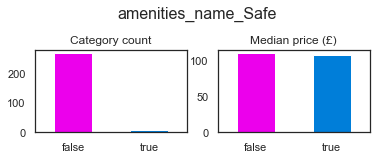

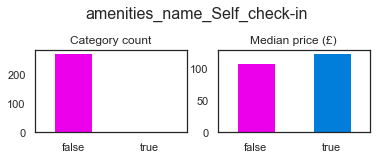

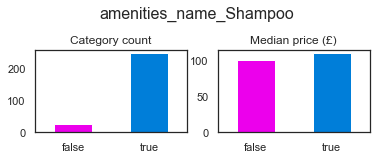

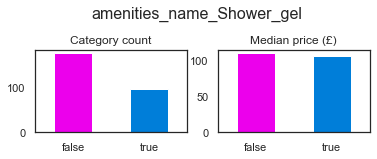

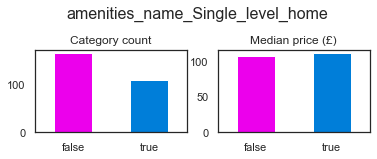

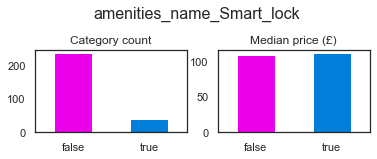

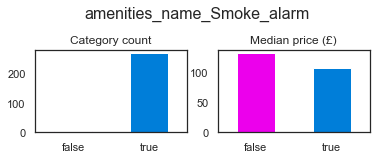

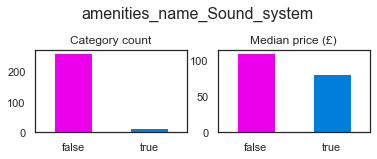

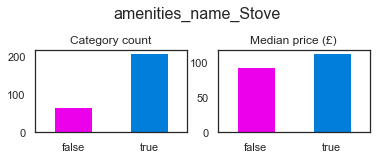

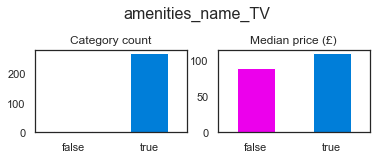

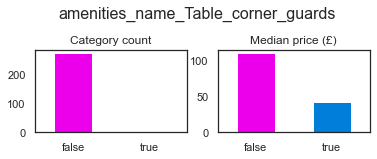

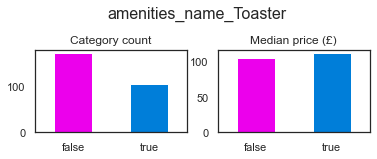

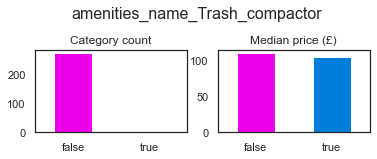

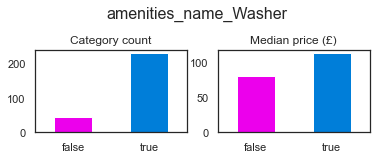

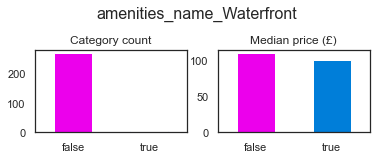

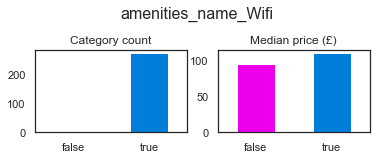

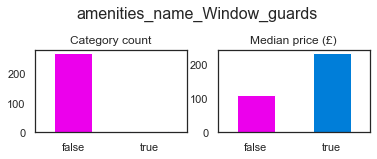

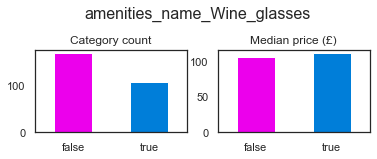

In [149]:
for col in df.iloc[:,16:].columns:
    binary_count_and_price_plot(col, figsize=(6,2))

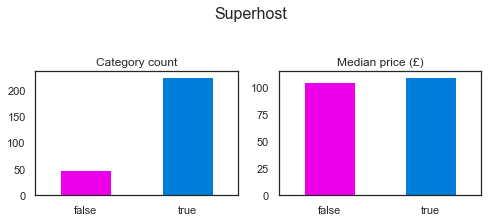

1    0.823529
0    0.176471
Name: Superhost, dtype: float64

In [150]:
binary_count_and_price_plot('Superhost')
print(df.Superhost.value_counts(normalize=True))

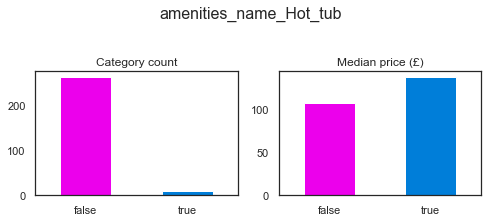

1    0.823529
0    0.176471
Name: Superhost, dtype: float64

In [151]:
binary_count_and_price_plot('amenities_name_Hot_tub')
print(df.Superhost.value_counts(normalize=True))

In [152]:
transformed_df = pd.get_dummies(df)

In [153]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

/var/folders/lb/lw726b6161v6kdxd72n1h19r0000gn/T/ipykernel_43545/1066291845.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


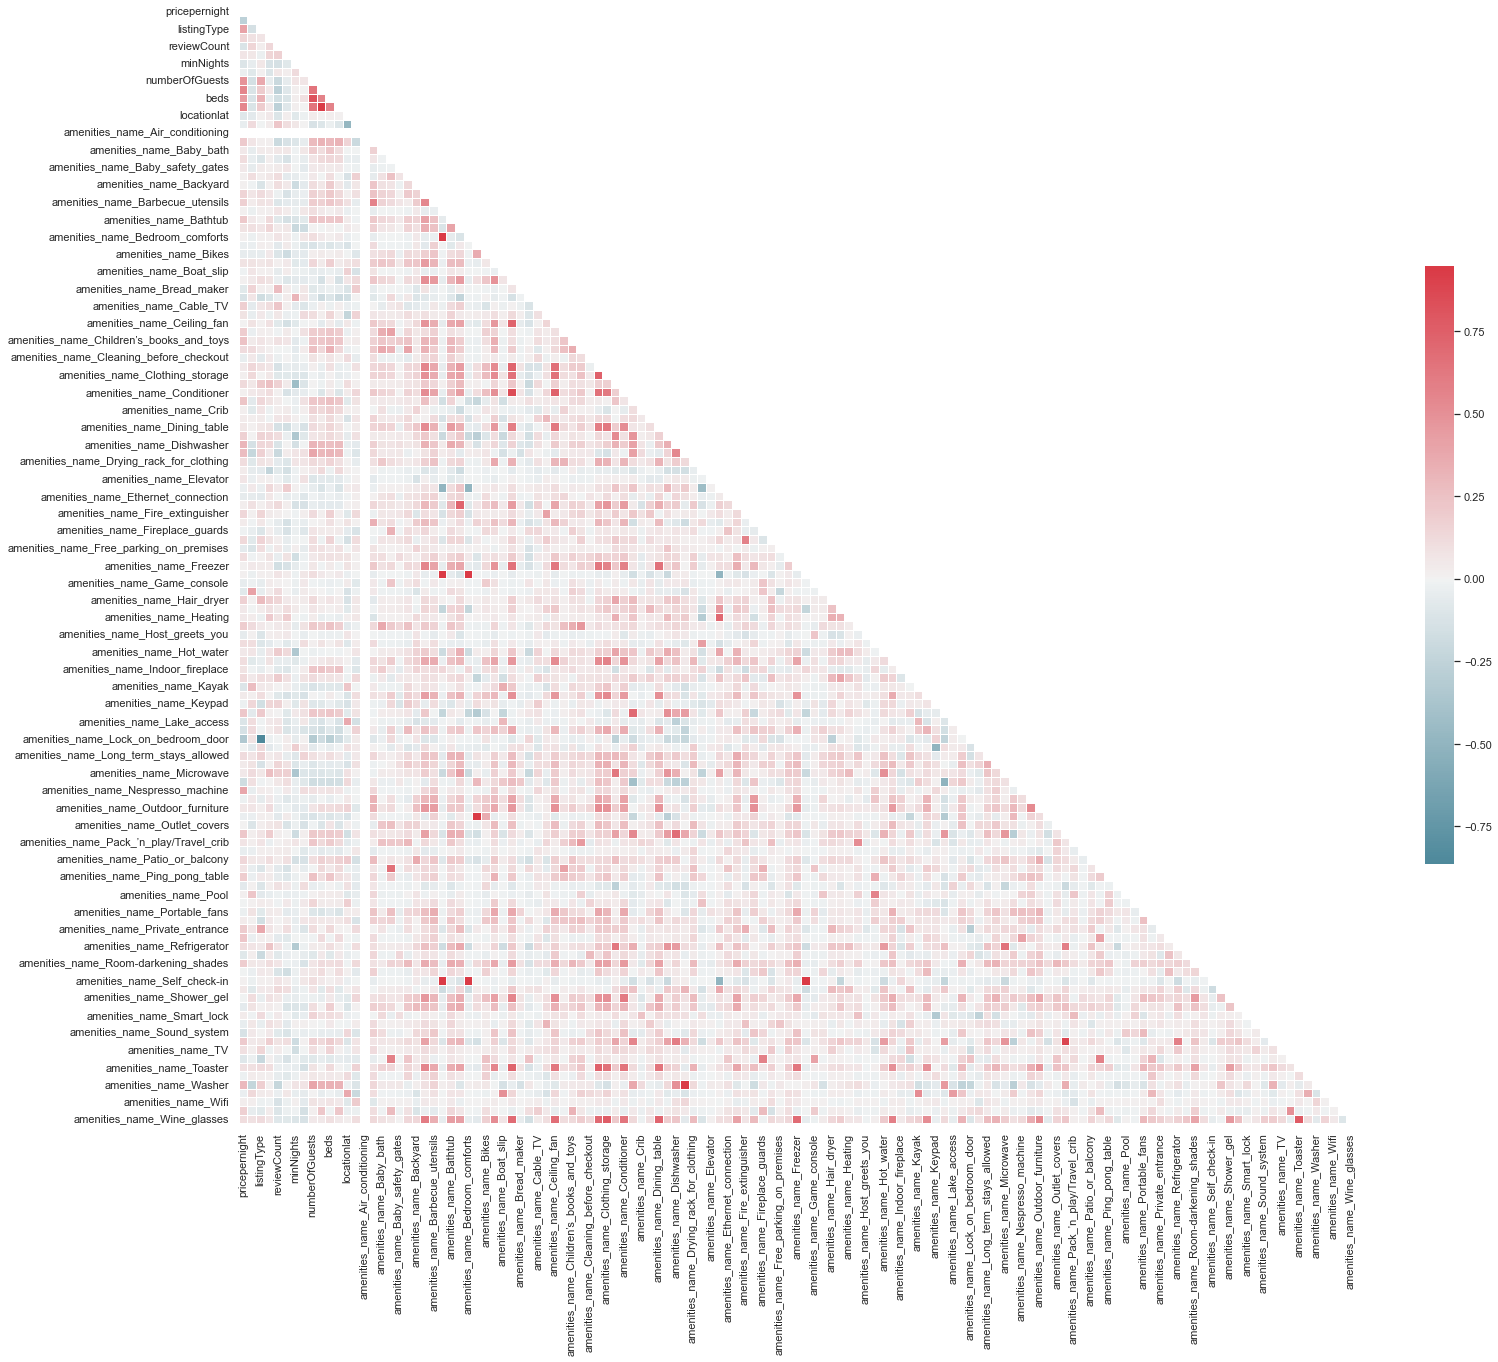

In [154]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('url')]), axis=1), figsize=(25,22))

In [155]:
# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [156]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

/Users/codyreece/Desktop/Repos/airbnb/air-scrape/venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Time taken to run: 0.0 minutes

Training MSE: 0.0

Validation MSE: 1141.4574

Training r2: 1.0

Validation r2: 0.6102

In [157]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
amenities_name_Outdoor_shower,0.000000
amenities_name_Bidet,0.000000
amenities_name_Self_check-in,0.000000
amenities_name_Boat_slip,0.000000
amenities_name_Bread_maker,0.000000
...,...
amenities_name_Dedicated_workspace,0.041835
listingType,0.115218
amenities_name_Nespresso_machine,0.119865
amenities_name_Sound_system,0.134113


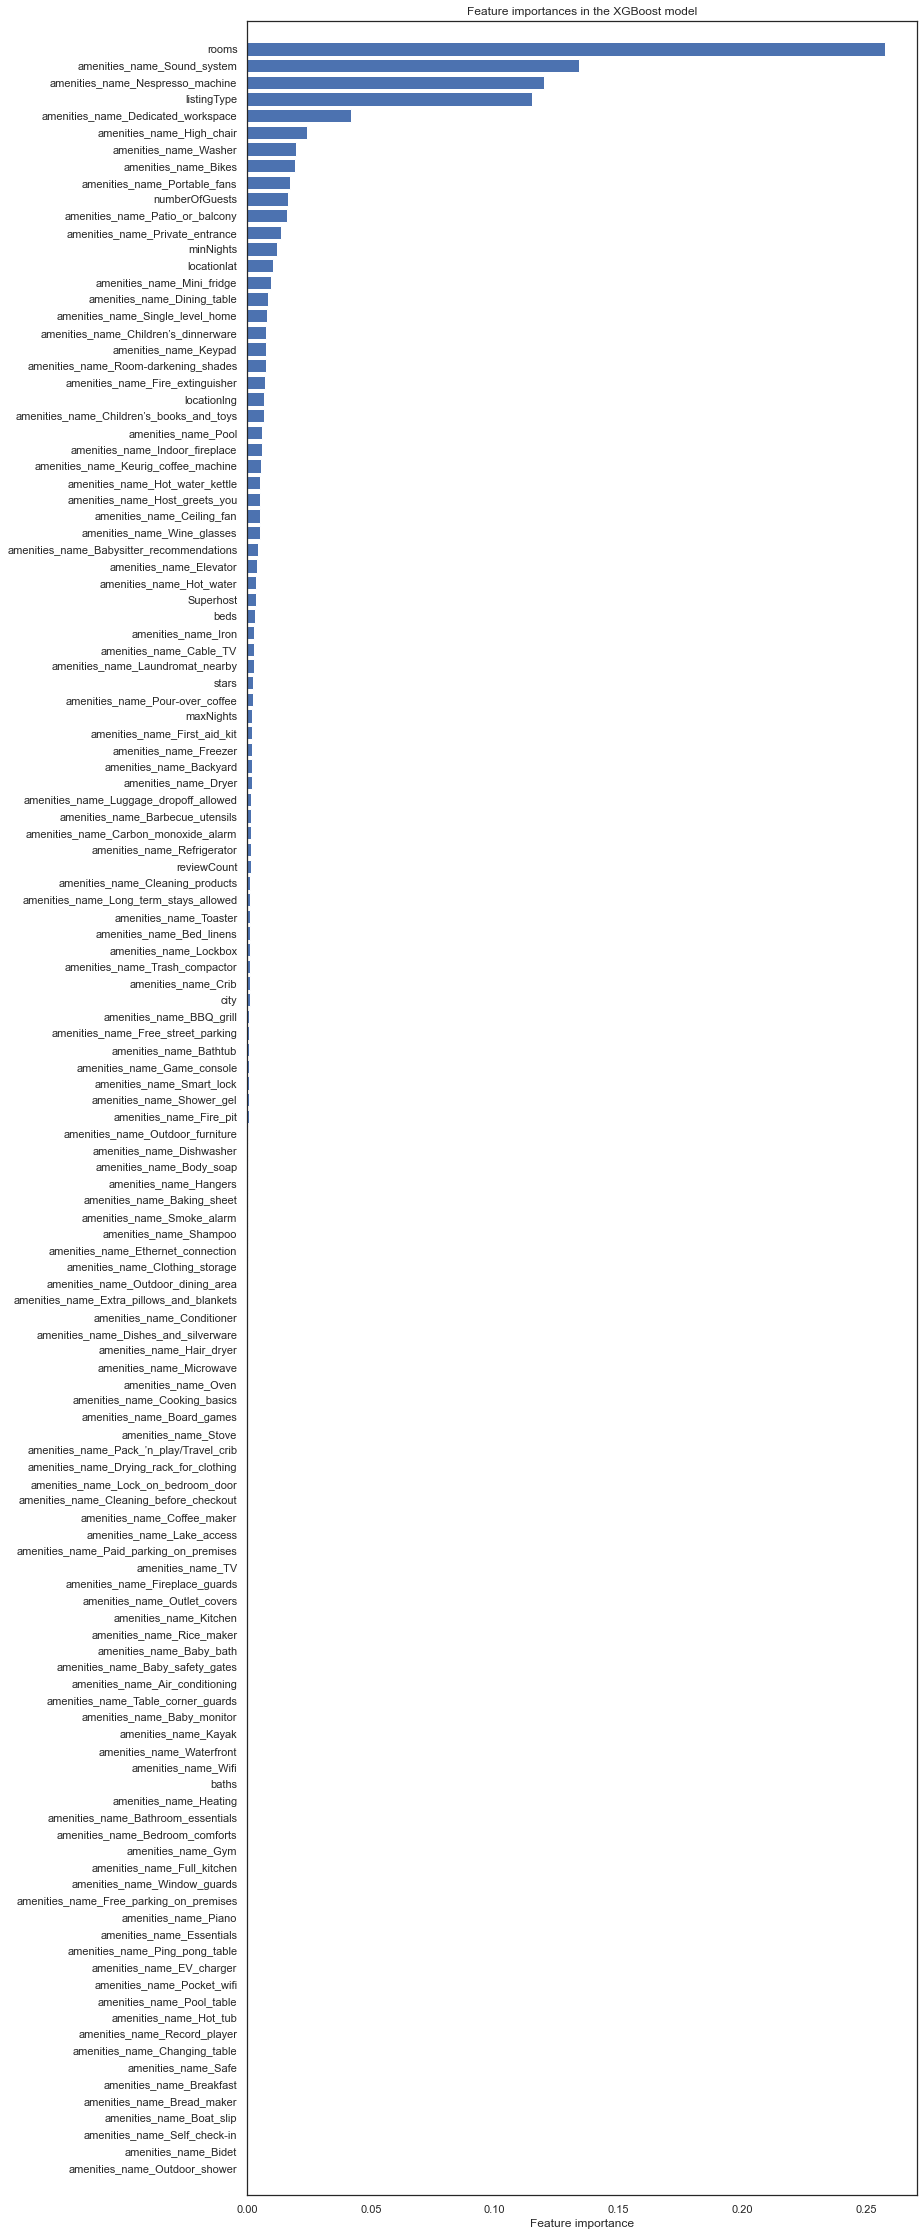

In [158]:
# Plotting feature importances
plt.figure(figsize=(12,40))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=12)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [159]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

# Visualising the neural network
SVG(model_to_dot(nn3, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 256)               33024     
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 dense_20 (Dense)            (None, 512)               131584    
                                                                 
 dense_21 (Dense)            (None, 1)                 513       
                                                                 
Total params: 247,425
Trainable params: 247,425
Non-trainable params: 0
_________________________________________________________________


None

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


AttributeError: 'NoneType' object has no attribute 'create'